In [1]:
from mvnc import mvncapi as mvnc
import numpy
import cv2
import sys

In [2]:
dim=(300,300)
EXAMPLES_BASE_DIR=''
#IMAGES_DIR = EXAMPLES_BASE_DIR + 'images/'
IMAGES_DIR = ''
IMAGE_FULL_PATH = IMAGES_DIR + 'office1.jpg'

In [3]:
# ***************************************************************
# Labels for the classifications for the network.
# ***************************************************************
LABELS = ('background',
          'aeroplane', 'bicycle', 'bird', 'boat',
          'bottle', 'bus', 'car', 'cat', 'chair',
          'cow', 'diningtable', 'dog', 'horse',
          'motorbike', 'person', 'pottedplant',
          'sheep', 'sofa', 'train', 'tvmonitor')

In [4]:
# Run an inference on the passed image
# image_to_classify is the image on which an inference will be performed
#    upon successful return this image will be overlayed with boxes
#    and labels identifying the found objects within the image.
# ssd_mobilenet_graph is the Graph object from the NCAPI which will
#    be used to peform the inference.
def run_inference(image_to_classify, ssd_mobilenet_graph):

    # get a resized version of the image that is the dimensions
    # SSD Mobile net expects
    resized_image = preprocess_image(image_to_classify)

    # ***************************************************************
    # Send the image to the NCS
    # ***************************************************************
    ssd_mobilenet_graph.LoadTensor(resized_image.astype(numpy.float16), None)

    # ***************************************************************
    # Get the result from the NCS
    # ***************************************************************
    output, userobj = ssd_mobilenet_graph.GetResult()

    #   a.      First fp16 value holds the number of valid detections = num_valid.
    #   b.      The next 6 values are unused.
    #   c.      The next (7 * num_valid) values contain the valid detections data
    #       Each group of 7 values will describe an object/box These 7 values in order.
    #       The values are:
    #         0: image_id (always 0)
    #         1: class_id (this is an index into labels)
    #         2: score (this is the probability for the class)
    #         3: box left location within image as number between 0.0 and 1.0
    #         4: box top location within image as number between 0.0 and 1.0
    #         5: box right location within image as number between 0.0 and 1.0
    #         6: box bottom location within image as number between 0.0 and 1.0

    # number of boxes returned
    num_valid_boxes = int(output[0])
    print('total num boxes: ' + str(num_valid_boxes))

    for box_index in range(num_valid_boxes):
            base_index = 7+ box_index * 7
            if (not numpy.isfinite(output[base_index]) or
                    not numpy.isfinite(output[base_index + 1]) or
                    not numpy.isfinite(output[base_index + 2]) or
                    not numpy.isfinite(output[base_index + 3]) or
                    not numpy.isfinite(output[base_index + 4]) or
                    not numpy.isfinite(output[base_index + 5]) or
                    not numpy.isfinite(output[base_index + 6])):
                # boxes with non infinite (inf, nan, etc) numbers must be ignored
                print('box at index: ' + str(box_index) + ' has nonfinite data, ignoring it')
                continue

            # clip the boxes to the image size incase network returns boxes outside of the image
            x1 = max(0, int(output[base_index + 3] * image_to_classify.shape[0]))
            y1 = max(0, int(output[base_index + 4] * image_to_classify.shape[1]))
            x2 = min(image_to_classify.shape[0], int(output[base_index + 5] * image_to_classify.shape[0]))
            y2 = min(image_to_classify.shape[1], int(output[base_index + 6] * image_to_classify.shape[1]))

            x1_ = str(x1)
            y1_ = str(y1)
            x2_ = str(x2)
            y2_ = str(y2)

            print('box at index: ' + str(box_index) + ' : ClassID: ' + LABELS[int(output[base_index + 1])] + '  '
                  'Confidence: ' + str(output[base_index + 2]*100) + '%  ' +
                  'Top Left: (' + x1_ + ', ' + y1_ + ')  Bottom Right: (' + x2_ + ', ' + y2_ + ')')

            # overlay boxes and labels on the original image to classify
            overlay_on_image(image_to_classify, output[base_index:base_index + 7])


In [5]:
# overlays the boxes and labels onto the display image.
# display_image is the image on which to overlay the boxes/labels
# object_info is a list of 7 values as returned from the network
#     These 7 values describe the object found and they are:
#         0: image_id (always 0 for myriad)
#         1: class_id (this is an index into labels)
#         2: score (this is the probability for the class)
#         3: box left location within image as number between 0.0 and 1.0
#         4: box top location within image as number between 0.0 and 1.0
#         5: box right location within image as number between 0.0 and 1.0
#         6: box bottom location within image as number between 0.0 and 1.0
# returns None
def overlay_on_image(display_image, object_info):

    # the minimal score for a box to be shown
    min_score_percent = 60

    source_image_width = display_image.shape[1]
    source_image_height = display_image.shape[0]

    base_index = 0
    class_id = object_info[base_index + 1]
    percentage = int(object_info[base_index + 2] * 100)
    if (percentage <= min_score_percent):
        # ignore boxes less than the minimum score
        return

    label_text = LABELS[int(class_id)] + " (" + str(percentage) + "%)"
    box_left = int(object_info[base_index + 3] * source_image_width)
    box_top = int(object_info[base_index + 4] * source_image_height)
    box_right = int(object_info[base_index + 5] * source_image_width)
    box_bottom = int(object_info[base_index + 6] * source_image_height)

    box_color = (255, 128, 0)  # box color
    box_thickness = 2
    cv2.rectangle(display_image, (box_left, box_top), (box_right, box_bottom), box_color, box_thickness)

    # draw the classification label string just above and to the left of the rectangle
    label_background_color = (125, 175, 75)
    label_text_color = (255, 255, 255)  # white text

    label_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    label_left = box_left
    label_top = box_top - label_size[1]
    if (label_top < 1):
        label_top = 1
    label_right = label_left + label_size[0]
    label_bottom = label_top + label_size[1]
    cv2.rectangle(display_image, (label_left - 1, label_top - 1), (label_right + 1, label_bottom + 1),
                  label_background_color, -1)

    # label text above the box
    cv2.putText(display_image, label_text, (label_left, label_bottom), cv2.FONT_HERSHEY_SIMPLEX, 0.5, label_text_color, 1)


In [6]:
# create a preprocessed image from the source image that complies to the
# network expectations and return it
def preprocess_image(src):

    # scale the image
    NETWORK_WIDTH = 300
    NETWORK_HEIGHT = 300
    img = cv2.resize(src, (NETWORK_WIDTH, NETWORK_HEIGHT))

    # adjust values to range between -1.0 and + 1.0
    img = img - 127.5
    img = img * 0.007843
    return img


total num boxes: 9
box at index: 0 : ClassID: chair  Confidence: 46.9970703125%  Top Left: (148, 760)  Bottom Right: (252, 1001)
box at index: 1 : ClassID: chair  Confidence: 44.677734375%  Top Left: (401, 451)  Bottom Right: (497, 755)
box at index: 2 : ClassID: chair  Confidence: 27.490234375%  Top Left: (61, 1014)  Bottom Right: (221, 1148)
box at index: 3 : ClassID: person  Confidence: 98.193359375%  Top Left: (241, 499)  Bottom Right: (397, 997)
box at index: 4 : ClassID: person  Confidence: 89.84375%  Top Left: (527, 498)  Bottom Right: (649, 909)
box at index: 5 : ClassID: person  Confidence: 59.521484375%  Top Left: (396, 300)  Bottom Right: (495, 731)
box at index: 6 : ClassID: person  Confidence: 53.955078125%  Top Left: (168, 320)  Bottom Right: (248, 808)
box at index: 7 : ClassID: person  Confidence: 45.556640625%  Top Left: (267, 71)  Bottom Right: (313, 353)
box at index: 8 : ClassID: person  Confidence: 36.474609375%  Top Left: (325, 179)  Bottom Right: (388, 500)


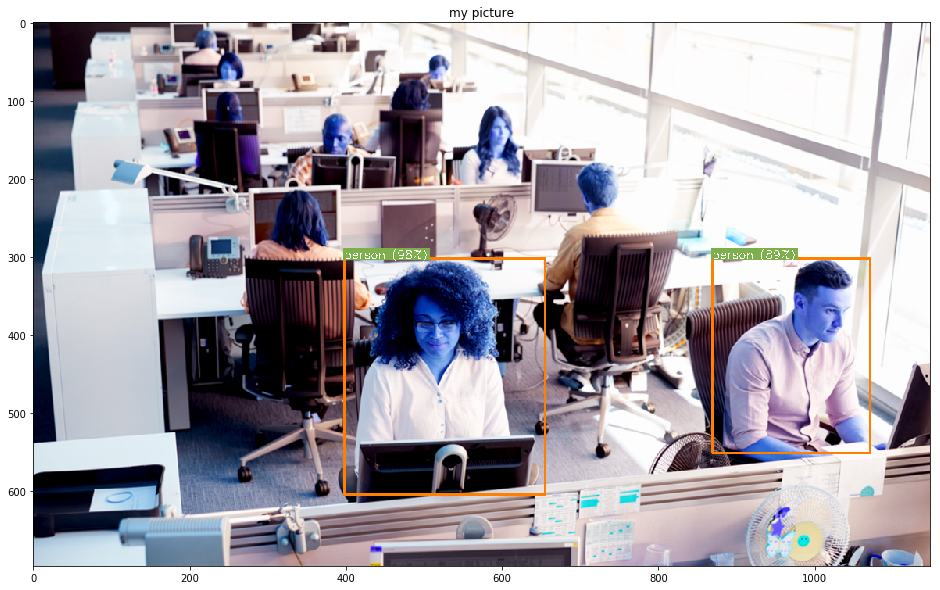

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

# name of the opencv window
cv_window_name = "SSD MobileNet - hit any key to exit"

# Get a list of ALL the sticks that are plugged in
# we need at least one
devices = mvnc.EnumerateDevices()
if len(devices) == 0:
    print('No devices found')
    quit()

# Pick the first stick to run the network
device = mvnc.Device(devices[0])

# Open the NCS
device.OpenDevice()

# The graph file that was created with the ncsdk compiler
graph_file_name = '/home/pi/ncappzoo/caffe/SSD_MobileNet/graph'

# read in the graph file to memory buffer
with open(graph_file_name, mode='rb') as f:
    graph_in_memory = f.read()

# create the NCAPI graph instance from the memory buffer containing the graph file.
graph = device.AllocateGraph(graph_in_memory)

# read the image to run an inference on from the disk
infer_image = cv2.imread(IMAGE_FULL_PATH)

# run a single inference on the image and overwrite the
# boxes and labels
run_inference(infer_image, graph)

# display the results and wait for user to hit a key
#cv2.imshow(cv_window_name, infer_image)
#cv2.waitKey(0)
plt.imshow(infer_image)
plt.title('my picture')
plt.show()

# Clean up the graph and the device
graph.DeallocateGraph()
device.CloseDevice()
